In [8]:
%pip install pandas 
%pip install seaborn
%pip install matplotlib.pyplot
%pip install mysql-connector-python


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for matplotlib.pyplot


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import mysql.connector 

conn = mysql.connector.connect(host = 'localhost',
             username='root',
             password='Manu@5805',
             database='covid19')

cur=conn.cursor()




In [ ]:
#  Total number of COVID-19 cases and deaths reported globally.

query= """Select sum(New_cases) as Total_cases_global, 
sum(New_deaths) as Total_deaths_global 
from covid19_global ; """

cur.execute(query)
data = cur.fetchall()
data 

In [13]:
# country having reported the highest cumulative cases and deaths.

query="""select Country
from covid19_global
group by Country 
having max(Cumulative_cases) and 
max(Cumulative_deaths) 
order by max(Cumulative_cases) and max(Cumulative_deaths) desc 
 limit 1 ; """

cur.execute(query)
data=cur.fetchall()
data 

[('Afghanistan',)]

In [14]:
# The top 5 countries by average new cases per day.
query= """select Country 
from covid19_global
group by Country
having avg(New_cases)
order by avg(New_cases) desc
limit 5 ; """

cur.execute(query)
data=cur.fetchall()
data 


[('United States of America',),
 ('China',),
 ('India',),
 ('France',),
 ('Germany',)]

In [15]:
# Total days of data available for each country

query="""select 
count(distinct ï»¿Date_reported ) as no_of_days 
from covid19_global 
group by Country 
Limit 1 ; """

cur.execute(query)
data=cur.fetchall()
data 


[(1414,)]

In [3]:
#  Date and country having highest number of new cases globally.

query="""select ï»¿Date_reported as Highest_Date,
Country 
from covid19_global 
group by ï»¿Date_reported ,Country
having max(New_cases)
Limit 1 ;"""

cur.execute(query)
data=cur.fetchall()
data 

[('26-02-2020', 'Afghanistan')]

In [4]:
# Fastest rising cases by time across WHO regions.

query=""" Select WHO_region,
Max(str_to_date( ï»¿Date_reported, "%d-%m-%Y")) as EndDate,
min(str_to_date(ï»¿Date_reported,"%d-%m-%Y") )as MinDate ,
Min(Cumulative_cases) as Startcase,
Max(Cumulative_cases) as Endcase ,
Round((Max(Cumulative_cases)-Min(Cumulative_cases))/ datediff(Max(str_to_date( ï»¿Date_reported, "%d-%m-%Y")),min(str_to_date(ï»¿Date_reported,"%d-%m-%Y") )), 3) as AvgCaseIncrease 
from covid19_global
group by WHO_region
order by AvgCaseIncrease desc ; """

cur.execute(query)
data=cur.fetchall()
columns=[col[0] for col in cur.description]
df=pd.DataFrame(data, columns=columns)

df


,WHO_region,EndDate,MinDate,Startcase,Endcase,AvgCaseIncrease
0,AMRO,2023-11-16,2020-01-03,0,103436829,73203.701
1,WPRO,2023-11-16,2020-01-03,0,99319332,70289.690
2,SEARO,2023-11-16,2020-01-03,0,45001456,31848.164
3,EURO,2023-11-16,2020-01-03,0,38997490,27599.073
4,EMRO,2023-11-16,2020-01-03,0,7623061,5394.948
5,AFRO,2023-11-16,2020-01-03,0,4072533,2882.189
6,Other,2023-11-16,2020-01-03,0,764,0.541


In [7]:
# 7 days rolling average 

query= """ WITH daily_cases AS (
  SELECT
    STR_TO_DATE(`ï»¿Date_reported`, '%d-%m-%Y') AS report_date,
    Country,
    Cumulative_cases,
    Cumulative_cases - LAG(Cumulative_cases) OVER (
      PARTITION BY Country ORDER BY STR_TO_DATE(`ï»¿Date_reported`, '%d-%m-%Y')
    ) AS new_cases
  FROM covid19_global
)

SELECT
  report_date,
  Country,
  new_cases,
  AVG(new_cases) OVER (
    PARTITION BY Country ORDER BY report_date
    ROWS BETWEEN 6 PRECEDING AND CURRENT ROW
  ) AS rolling_avg
FROM daily_cases; """ 

cur.execute(query)
data=cur.fetchall()
columns=[col[0] for col in cur.description]
df=pd.DataFrame(data, columns=columns)
df




,report_date,Country,new_cases,rolling_avg
0,2020-01-03,Afghanistan,NaN,None
1,2020-01-03,Afghanistan,0.0,0.0000
2,2020-01-03,Afghanistan,0.0,0.0000
3,2020-01-03,Afghanistan,0.0,0.0000
4,2020-01-03,Afghanistan,0.0,0.0000
...,...,...,...,...
1365954,2023-11-12,Zimbabwe,0.0,0.0000
1365955,2023-11-13,Zimbabwe,0.0,0.0000
1365956,2023-11-14,Zimbabwe,0.0,0.0000
1365957,2023-11-15,Zimbabwe,0.0,0.0000


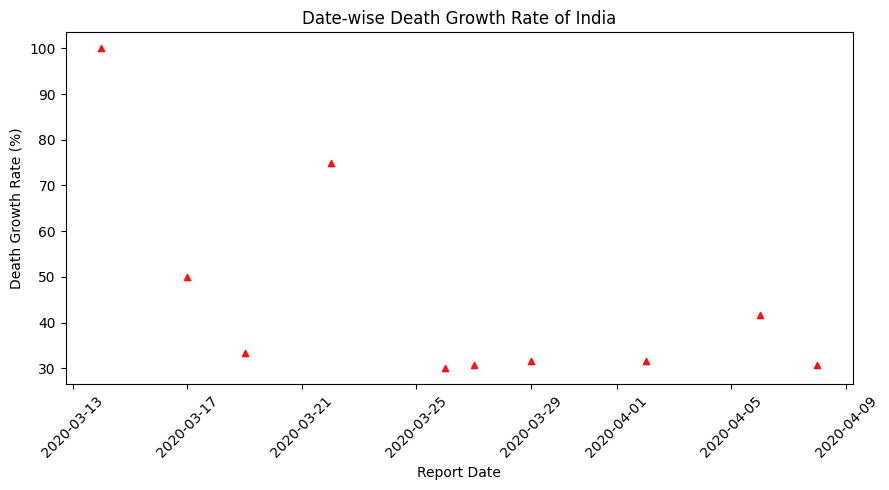

In [29]:
# Plot the death growth rate of India.  

query= """ WITH death_data AS (
  SELECT
    STR_TO_DATE(`ï»¿Date_reported`, '%d-%m-%Y') AS report_date,
    Country,
    Cumulative_deaths,
    LAG(Cumulative_deaths) OVER (
      PARTITION BY Country ORDER BY STR_TO_DATE(`ï»¿Date_reported`, '%d-%m-%Y')
    ) AS prev_deaths
  FROM covid19_global
)

SELECT
  report_date,
  Country,
  Cumulative_deaths,
  prev_deaths,
  ROUND(
    CASE
      WHEN prev_deaths = 0 OR prev_deaths IS NULL THEN NULL
      ELSE ((Cumulative_deaths - prev_deaths) / prev_deaths) * 100
    END, 2
  ) AS death_growth_rate
FROM death_data
WHERE Country = 'India'
order by death_growth_rate desc 
limit 10 ; """

cur.execute(query)
data=cur.fetchall()
columns=[col[0] for col in cur.description]
df=pd.DataFrame(data, columns=columns)
df

import matplotlib.pyplot as plt

plt.figure(figsize=(9,5)) 

plt.scatter(x=df['report_date'], y=df['death_growth_rate'], s=20, marker='^', color='r', alpha=0.9) 
plt.title('Date-wise Death Growth Rate of India')
plt.xlabel('Report Date')
plt.ylabel('Death Growth Rate (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




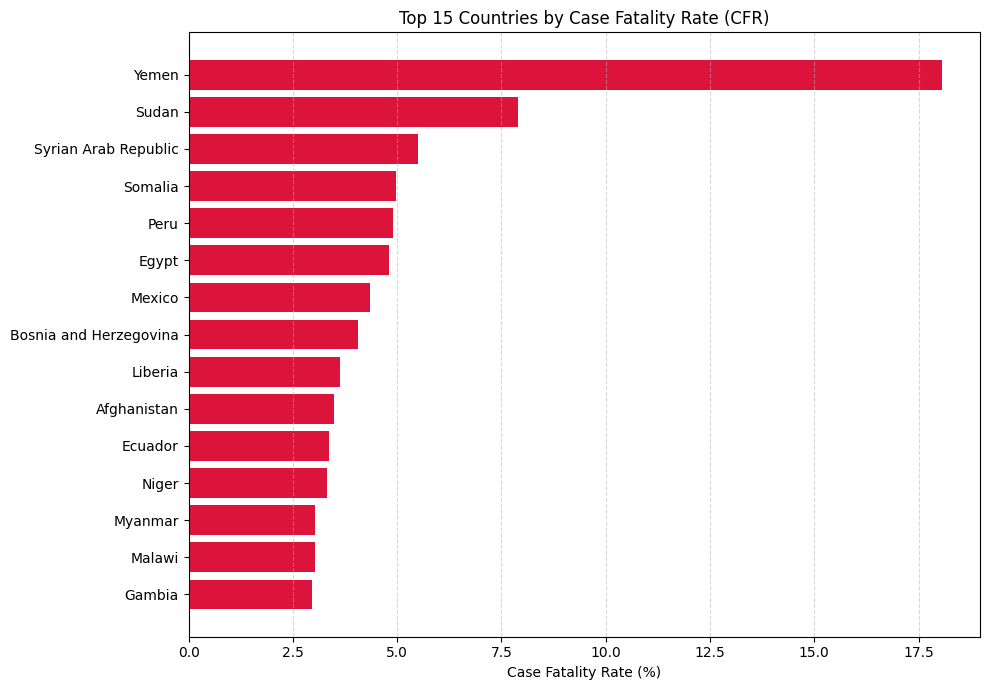

In [4]:
# Plotting top 15 countries by Case Fatality Rate 

query= """ SELECT
  Country,
  MAX(Cumulative_cases) AS total_cases,
  MAX(Cumulative_deaths) AS total_deaths,
  ROUND(
    (MAX(Cumulative_deaths) / NULLIF(MAX(Cumulative_cases), 0)) * 100, 2
  ) AS case_fatality_rate
FROM covid19_global
GROUP BY Country
ORDER BY case_fatality_rate DESC; """ 

cur.execute(query)
data=cur.fetchall()
columns=[col[0] for col in cur.description]
df=pd.DataFrame(data, columns=columns)
df

import matplotlib.pyplot as plt


top_cfr = df.sort_values(by='case_fatality_rate', ascending=False).head(15)

plt.figure(figsize=(10, 7))
plt.barh(top_cfr['Country'], top_cfr['case_fatality_rate'], color='crimson')
plt.xlabel('Case Fatality Rate (%)')
plt.title('Top 15 Countries by Case Fatality Rate (CFR)')
plt.gca().invert_yaxis()  
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



In [7]:
import pandas as pd

df = pd.read_csv(r"C:\Imp things\Data Analytics\Python+sql (project)\covid19_global.csv", encoding='latin1')
df.describe()




,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
count,3.351180e+05,3.351180e+05,335118.000000,3.351180e+05
mean,2.303699e+03,1.535676e+06,20.827846,1.845291e+04
std,3.851160e+04,6.943032e+06,164.849599,7.687598e+04
min,-6.507900e+04,0.000000e+00,-3520.000000,0.000000e+00
25%,0.000000e+00,2.779000e+03,0.000000,2.100000e+01
50%,0.000000e+00,3.800800e+04,0.000000,4.110000e+02
75%,1.420000e+02,4.482015e+05,1.000000,5.938000e+03
max,6.966046e+06,1.034368e+08,43994.000000,1.138309e+06


<function matplotlib.pyplot.show(close=None, block=None)>

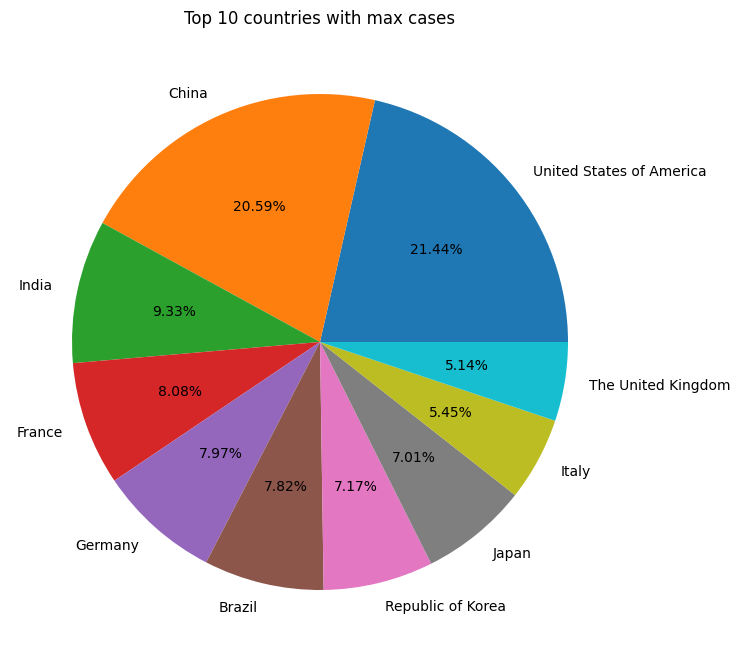

In [1]:
# Countries with maximum cases 

import pandas as pd 
df = pd.read_csv(r"C:\Imp things\Data Analytics\Python+sql (project)\covid19_global.csv", encoding='latin1')
country_cases=df.groupby("Country")["Cumulative_cases"].max().reset_index()
top_10=country_cases.sort_values(by="Cumulative_cases", ascending=False).head(10) 

import matplotlib.pyplot as plt
plt.figure(figsize=(8,9))
plt.pie(top_10["Cumulative_cases"],labels=top_10["Country"], autopct="%1.2f%%")
plt.title("Top 10 countries with highest cases")
plt.legend
plt.show

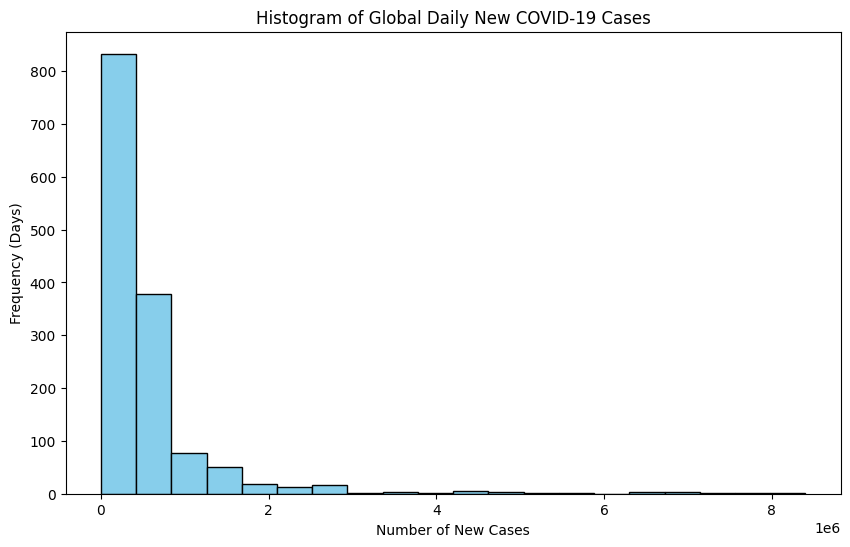

In [28]:
# Daily new cases reported 

import pandas as pd 
df = pd.read_csv(r"C:\Imp things\Data Analytics\Python+sql (project)\covid19_global.csv", encoding='latin1')
df["Date_reported"]=pd.to_datetime(df['Date_reported'], dayfirst=True) 
cases=df.groupby("Date_reported")["Cumulative_cases"].sum().reset_index() 
cases["New_cases"]=cases["Cumulative_cases"].diff().fillna(0)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.hist(cases["New_cases"], bins=20,color='skyblue', edgecolor='black')
plt.title("Histogram of Global Daily New COVID-19 Cases")
plt.xlabel("Number of New Cases")
plt.ylabel("Frequency (Days)")
plt.show()

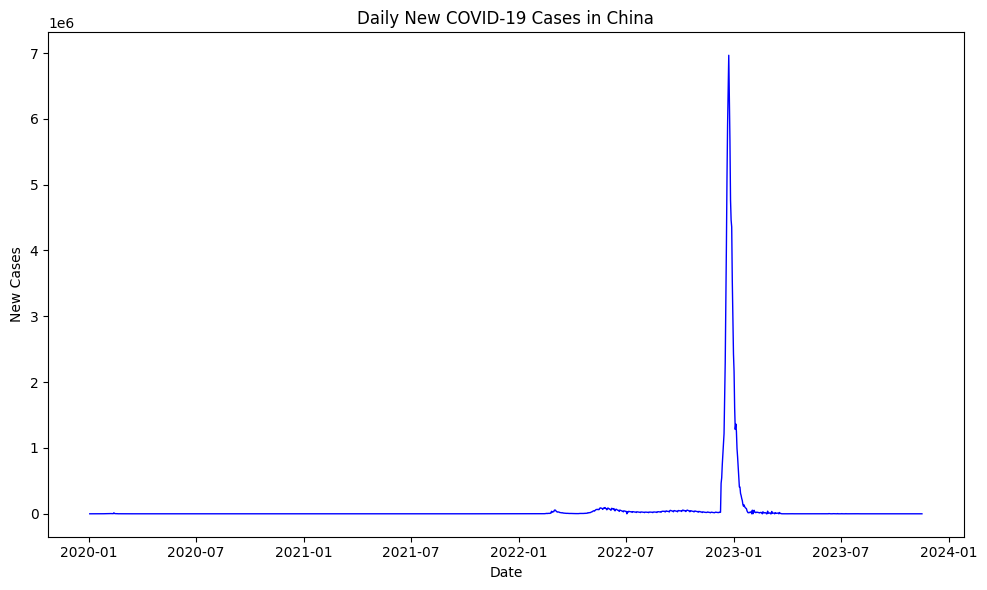

In [14]:
# Date wise new cases in China 

import pandas as pd 
df = pd.read_csv(r"C:\Imp things\Data Analytics\Python+sql (project)\covid19_global.csv", encoding='latin1')
df["Date_reported"]=pd.to_datetime(df['Date_reported'], dayfirst=True) 
country_name="China"
Country_df=df[df["Country"]== country_name].copy()
Country_df.sort_values("Date_reported",inplace=True)
Country_df["New_cases"]=Country_df["Cumulative_cases"].diff().fillna(0)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(Country_df["Date_reported"], Country_df["New_cases"], color='blue', linewidth=1)
plt.title(f'Daily New COVID-19 Cases in {country_name}')
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.tight_layout()
plt.show()



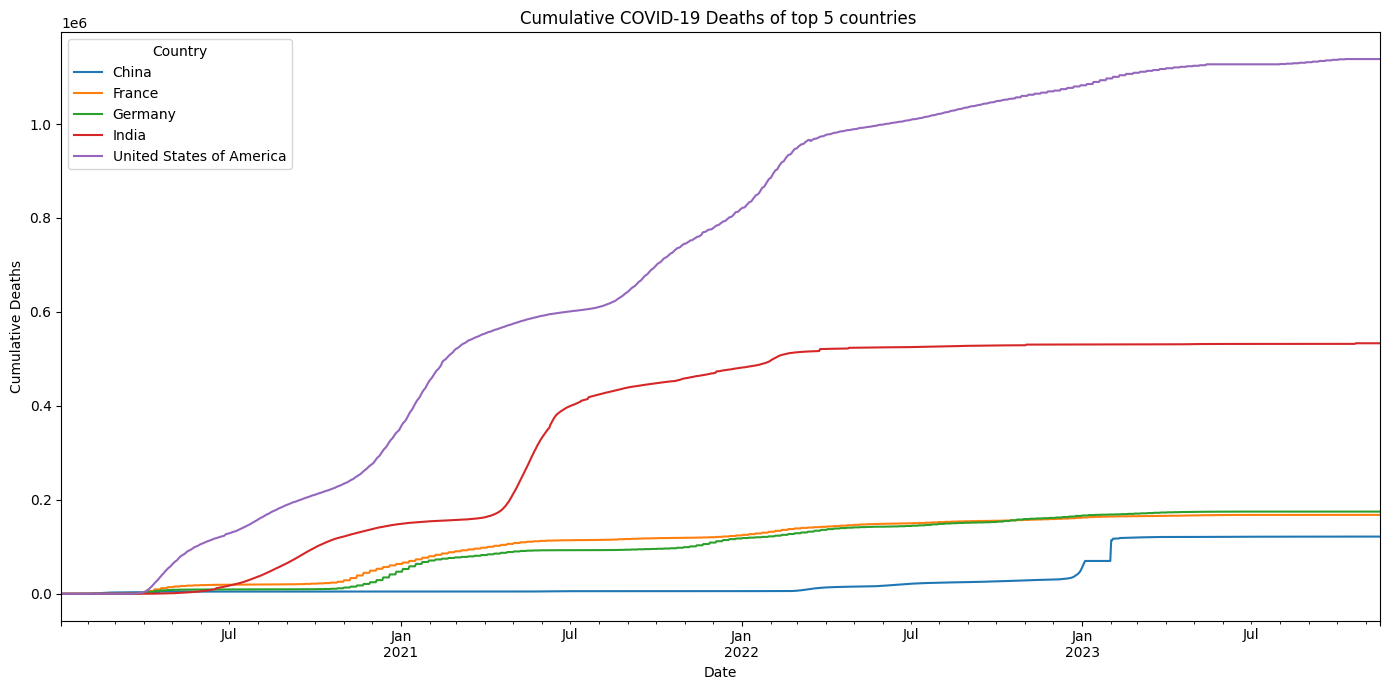

In [14]:
# Death comparison between top 5 countries 

import pandas as pd 
df = pd.read_csv(r"C:\Imp things\Data Analytics\Python+sql (project)\covid19_global.csv", encoding='latin1')

df['Date_reported']=pd.to_datetime(df['Date_reported'], dayfirst=True)
countries=['India','China','United States of America','France','Germany']
selected_df=df[df['Country'].isin(countries)]

pivot_df = selected_df.pivot_table(
    index='Date_reported',
    columns='Country',
    values='Cumulative_deaths',
    aggfunc='sum'
).fillna(0)

pivot_df.plot(figsize=(14,7), markersize='10')
plt.title("Cumulative COVID-19 Deaths of top 5 countries ")
plt.xlabel("Date")
plt.ylabel("Cumulative Deaths")
plt.legend(title="Country")
plt.tight_layout()
plt.show()



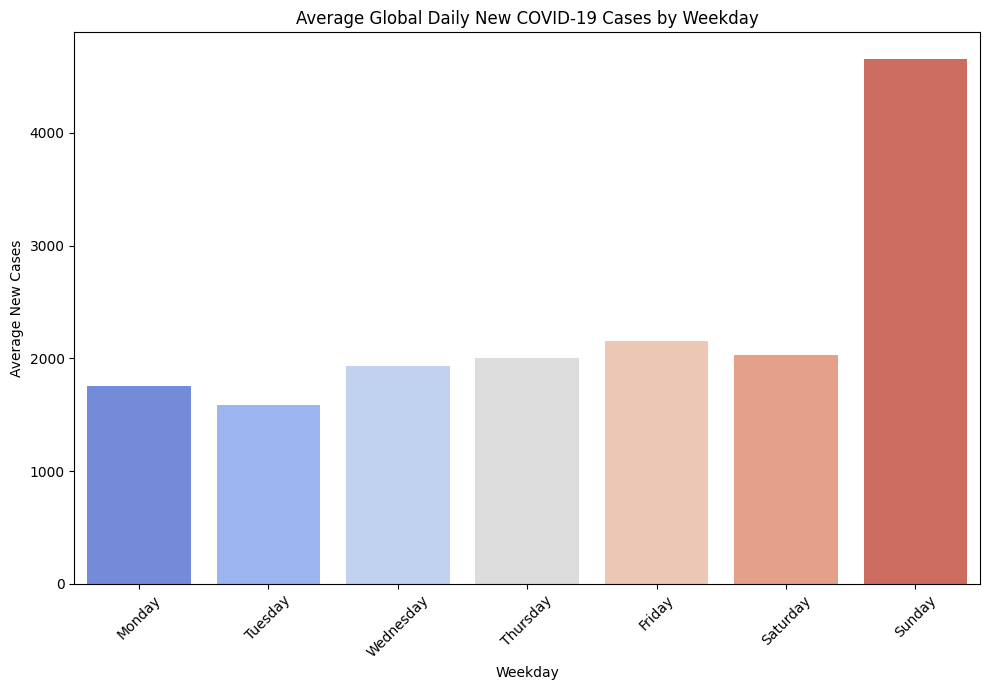

In [26]:
# Day wise average cases reported 

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.read_csv(r"C:\Imp things\Data Analytics\Python+sql (project)\covid19_global.csv", encoding='latin1')
df["Date_reported"] = pd.to_datetime(df["Date_reported"], dayfirst=True)
df.sort_values(by=['Country', 'Date_reported'], inplace=True)

df['new_cases'] = df.groupby('Country')['Cumulative_cases'].diff().fillna(0)
df['weekday'] = df['Date_reported'].dt.day_name()

weekday_avg = df.groupby('weekday')['new_cases'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])


plt.figure(figsize=(10, 7))
sns.barplot(x=weekday_avg.index, y=weekday_avg.values, hue=weekday_avg.index,  palette="coolwarm", legend=False )

plt.title('Average Global Daily New COVID-19 Cases by Weekday')
plt.ylabel('Average New Cases')
plt.xlabel('Weekday')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




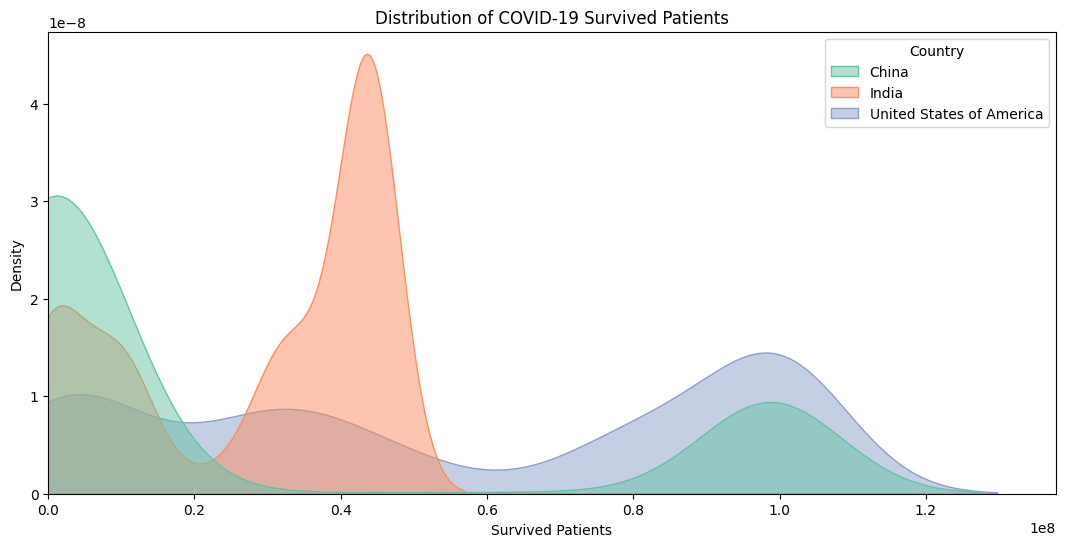

In [10]:
# Survived Patients data for 3 Top countries 

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.read_csv(r"C:\Imp things\Data Analytics\Python+sql (project)\covid19_global.csv", encoding='latin1')
df['Date_reported'] = pd.to_datetime(df['Date_reported'], dayfirst=True)

selected_countries = ['India', 'China', 'United States of America']
df = df[df['Country'].isin(selected_countries)]
df['Survived'] = df['Cumulative_cases'] - df['Cumulative_deaths']
df = df[df['Survived'] >=0 
plt.figure(figsize=(13, 6))
    
sns.kdeplot(data=df, x='Survived', hue='Country', fill=True, common_norm=False, alpha=0.5, palette='Set2')
plt.title('Distribution of COVID-19 Survived Patients')
plt.xlabel('Survived Patients')
plt.ylabel('Density')
plt.xlim(0,)  
plt.show()





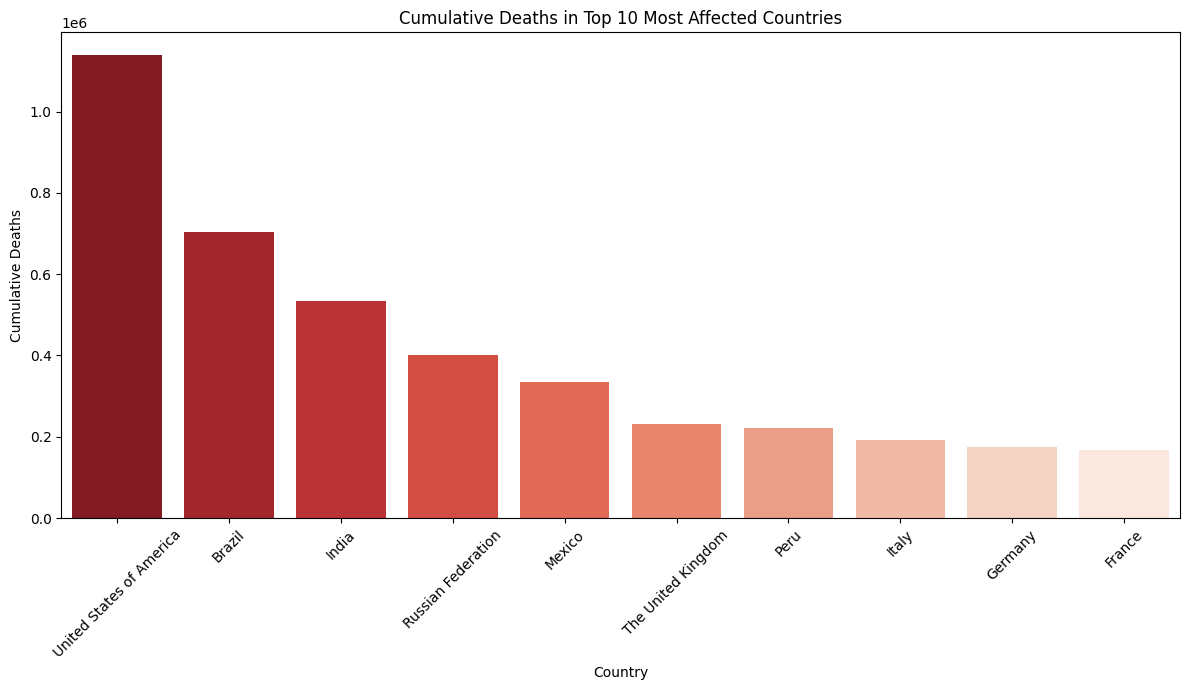

In [24]:
# Cumulative deaths in top 10 countries 

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.read_csv(r"C:\Imp things\Data Analytics\Python+sql (project)\covid19_global.csv", encoding='latin1')
df['Date_reported'] = pd.to_datetime(df['Date_reported'], dayfirst=True)

latest = df.sort_values('Date_reported').groupby('Country').last().reset_index()

top10 = latest.sort_values(by='Cumulative_deaths', ascending=False).head(10)

plt.figure(figsize=(12,7))
sns.barplot(data=top10, x='Country', y='Cumulative_deaths', hue='Country', palette='Reds_r', legend=False )

plt.title('Cumulative Deaths in Top 10 Most Affected Countries')
plt.xlabel('Country')
plt.ylabel('Cumulative Deaths')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Text(0.5, 1.0, 'Avg Deaths per day ')

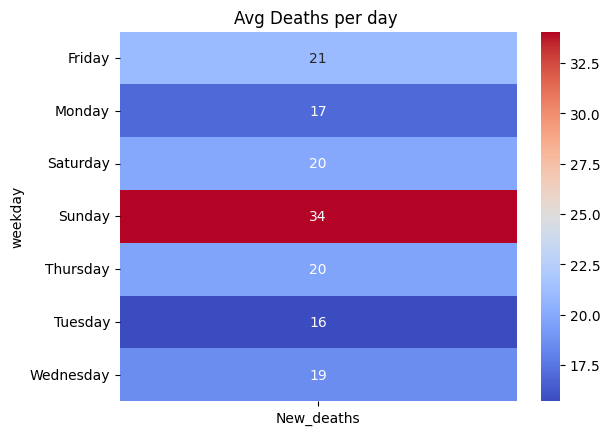

In [19]:
# Avg deaths per day by heatmap 

df['weekday'] = df['Date_reported'].dt.day_name()
pivot = df.pivot_table(values='New_deaths', index='weekday', aggfunc='mean')
sns.heatmap(pivot, annot=True, cmap='coolwarm')
plt.title('Avg Deaths per day ') 
plt.figure(figsize=(10,6)) 





Text(0.5, 1.0, 'Deaths per day before & after lockdown ')

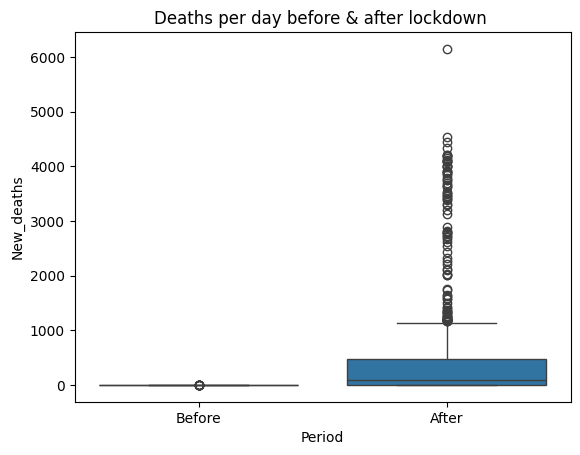

In [23]:
# Death comparison before & after lockdown in India 

df['Period'] = df['Date_reported'].apply(lambda x: 'Before' if x < pd.to_datetime('2020-04-01') else 'After')
sns.boxplot(data=df[df['Country'] == 'India'], x='Period', y='New_deaths')
plt.title('Deaths per day before & after lockdown ') 



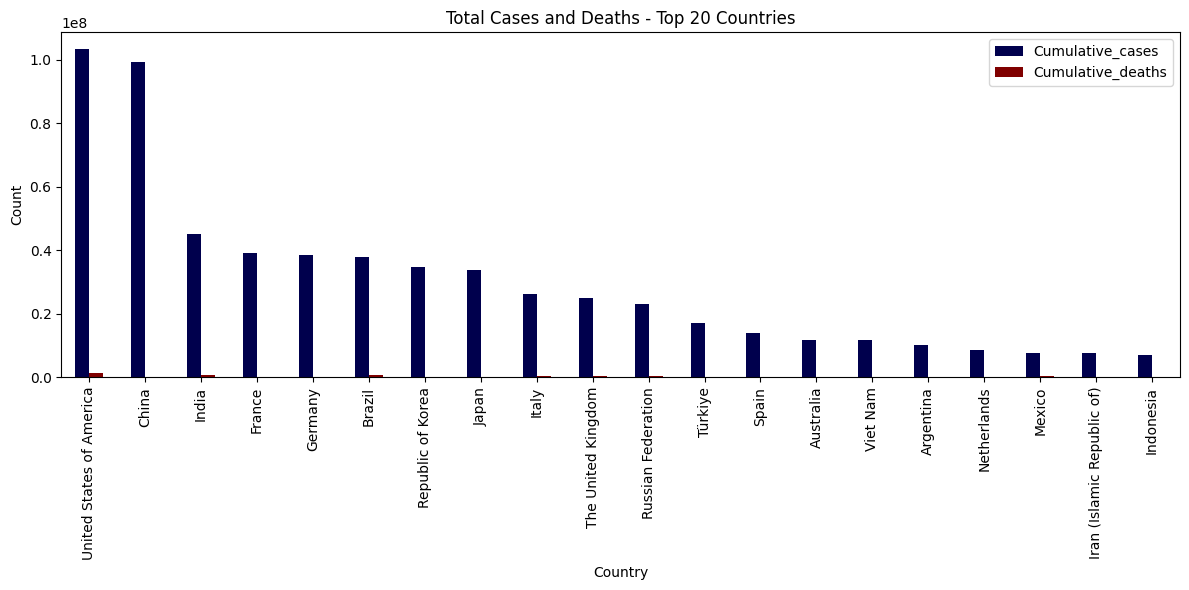

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.read_csv(r"C:\Imp things\Data Analytics\Python+sql (project)\covid19_global.csv", encoding='latin1')

top = df.groupby('Country')[['Cumulative_cases', 'Cumulative_deaths']].max().nlargest(20, 'Cumulative_cases')
top.plot(kind='bar', figsize=(12,6), colormap='seismic')
plt.title('Total Cases and Deaths - Top 20 Countries')
plt.ylabel('Count')
plt.tight_layout()
plt.show()
